<h1 style="font-size:2em">Projet 6 - Classifiez automatiquement des biens de consommation</h1>


# Objectifs

# Imports et configs

In [1]:
import pandas as pd 
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('df_t.csv')

In [3]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category,_lon_desc,cleaned_description,stop_removed_description,tokenized,lemmatized,lemmatize_joined,Nombre de mots après nettoyage
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,1420,features elegance polyester multicolor abstrac...,features elegance polyester multicolor abstrac...,"['features', 'elegance', 'polyester', 'multico...","['feature', 'elegance', 'polyester', 'multicol...",feature elegance polyester multicolor abstract...,141
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,444,specifications sathiyas cotton bath towel bath...,specifications sathiyas cotton bath towel bath...,"['specifications', 'sathiyas', 'cotton', 'bath...","['specifications', 'sathiyas', 'cotton', 'bath...",specifications sathiyas cotton bath towel bath...,55
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,1258,features eurospa cotton terry face towel size ...,features eurospa cotton terry face towel size ...,"['features', 'eurospa', 'cotton', 'terry', 'fa...","['feature', 'eurospa', 'cotton', 'terry', 'fac...",feature eurospa cotton terry face towel size s...,131
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,858,features santosh royal fashion cotton printed ...,features santosh royal fashion cotton printed ...,"['features', 'santosh', 'royal', 'fashion', 'c...","['feature', 'santosh', 'royal', 'fashion', 'co...",feature santosh royal fashion cotton print kin...,102
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,1197,features jaipur print cotton floral king sized...,features jaipur print cotton floral king sized...,"['features', 'jaipur', 'print', 'cotton', 'flo...","['feature', 'jaipur', 'print', 'cotton', 'flor...",feature jaipur print cotton floral king size d...,134


# Définir la stratégie d’élaboration d’un modèle d'apprentissage profond, concevoir ou ré-utiliser des modèles pré-entraînés (transfer learning) et entraîner des modèles afin de réaliser une analyse prédictive.

## CE1 Vous avez défini votre stratégie d’élaboration d’un modèle pour répondre à un besoin métier (par exemple : choix de conception d’un modèle ré-utilisation de modèles pré-entraînés.

- **Préparation des données:** Séparation des données en ensembles d'entraînement, de validation et de test.
    - **Train:** Permet d'entrainer le modèle
    - **Validation:** Permet de trouver les bonnes valeurs des hypermaramètres
    - **Test:** Permet de vérifier que le modèle est robuste avec de nouvelles données
- **Elaboration d'un modèle:** Utilisation d'un modèle pré-entrainé

## CE2 Vous avez identifié la ou les cibles. 

Les cibles sont les 7 labels présents dans df['category_lvl_1']

In [4]:
# Check the distribution of the categories in 'category_lvl_1'
category_distribution = df['category'].value_counts()

category_distribution

category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

La distribution des catégories est parfaitement équilibrée, ce qui est idéal pour la formation de modèles d'apprentissage machine.

### Création de X

In [5]:
import os
import numpy as np

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from PIL import Image

# Augmenter la limite par défaut (ici, par exemple, fixée à une valeur très élevée)
Image.MAX_IMAGE_PIXELS = None 

def image_prep_fct(df):
    # Définir le chemin d'accès relatif aux images
    base_image_path = "Images"

    prepared_images = []
    for image_name in df['image']:
        # Construire le chemin complet de l'image
        image_path = os.path.join(base_image_path, image_name)

        # Charger, traiter et prétraiter l'image
        img = load_img(image_path, target_size=(224, 224))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)

    prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np = image_prep_fct(df)
X = images_np
print(X.shape)

(1050, 224, 224, 3)


In [6]:
images_np

array([[[[  88.061     ,   87.221     ,   82.32      ],
         [  87.061     ,   86.221     ,   81.32      ],
         [  89.061     ,   85.221     ,   81.32      ],
         ...,
         [  53.060997  ,   49.221     ,   51.32      ],
         [  54.060997  ,   50.221     ,   52.32      ],
         [  53.060997  ,   49.221     ,   51.32      ]],

        [[  99.061     ,   91.221     ,   83.32      ],
         [  97.061     ,   89.221     ,   83.32      ],
         [  98.061     ,   90.221     ,   84.32      ],
         ...,
         [  56.060997  ,   52.221     ,   54.32      ],
         [  54.060997  ,   50.221     ,   52.32      ],
         [  55.060997  ,   51.221     ,   53.32      ]],

        [[  99.061     ,   90.221     ,   84.32      ],
         [ 103.061     ,   92.221     ,   86.32      ],
         [ 103.061     ,   92.221     ,   86.32      ],
         ...,
         [  55.060997  ,   51.221     ,   53.32      ],
         [  56.060997  ,   52.221     ,   54.32      ],
  

### Création de Y

In [8]:
from sklearn.preprocessing import LabelEncoder

# Initialisation du LabelEncoder
label_encoder = LabelEncoder()

# Convertir les labels texte en labels numériques
y_encoded = label_encoder.fit_transform(df['category'])

# Conversion des labels numériques en one-hot encoding
y = to_categorical(y_encoded)

print(y.shape)

(1050, 7)


## CE3 Vous avez réalisé la séparation du jeu de données en jeu d’entraînement, jeu de validation et jeu de test. 

- 70% pour l'entraînement
- 15% pour la validation
- 15% pour le test

In [9]:
from sklearn.model_selection import train_test_split

X_temp, X_train, y_temp, y_train = train_test_split(X, y, test_size=0.7, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [10]:
print("La forme de X_train est :", X_train.shape)
print("La forme de X_val est :", X_val.shape)
print("La forme de X_test est :", X_val.shape)

La forme de X_train est : (735, 224, 224, 3)
La forme de X_val est : (157, 224, 224, 3)
La forme de X_test est : (157, 224, 224, 3)


## CE4 Vous vous êtes assurés qu'il n’y a pas de fuite d’information entre les deux jeux de données (entraînement, validation et test). 

On a utilisé la stratification lors de la séparation. Cela garantit que la distribution des catégories est maintenue uniformément dans tous les sous-ensembles

## CE5 Vous avez testé plusieurs modèles d’apprentissage profond (par exemple à l’aide de la librairie Tensorflow / Keras) en partant du plus simple vers les plus complexes. 

### Modèle simple (Perceptron multicouche entièrement connecté)

**Pile linéaire de couches.**

**1ère couche de mise à plat (Flatten):** 
- Convertit les images 2D de forme (224, 224, 3) en un vecteur 1D

**Deux couches denses (ou entièrement connectées):**
- La première a 128 neurones et utilise la fonction d'activation ReLU.
- La deuxième a 64 neurones avec la même fonction d'activation.

**La dernière couche est également une couche dense:**
- 7 neurones -> 7 classes pour lesquelles le modèle est censé prédire. 
- La fonction d'activation softmax est utilisée pour convertir les sorties en probabilités pour chaque classe.

In [11]:
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

model_mlp = Sequential()
model_mlp.add(Flatten(input_shape=(224, 224, 3))) # Convertir les images 2D en vecteur 1D
model_mlp.add(Dense(128, activation='relu'))
model_mlp.add(Dense(64, activation='relu'))
model_mlp.add(Dense(7, activation='softmax')) # 7 classes, donc 7 neurones en sortie

model_mlp.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model_mlp.summary()

# Initialisation de l'arrêt anticipé
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Enregistrement du temps de début
start_time = time.time()

pred = model_mlp.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Enregistrement du temps de fin
end_time = time.time()

# Calculer et afficher le temps écoulé
elapsed_time = end_time - start_time
print("")
print(f"Temps écoulé pour l'entraînement: {elapsed_time:.2f} secondes")

# Évaluation du modèle sur l'ensemble de test
test_loss, test_accuracy = model_mlp.evaluate(X_test, y_test)
print("")
print(f"Score du test : test_loss = {test_loss:.4f}, test_accuracy = {test_accuracy:.4f}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 128)               19267712  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                                 
Total params: 19,276,423
Trainable params: 19,276,423
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
23/23 [==============================] - 10s 400ms/step - loss: 9066.4961 - accuracy: 0.1878 - val_loss: 3987.4099 - val_accuracy: 0.2293
Epoch 2/15
23/23 [=========

### Modèle de complexité médium (CNN = Réseau neuronal convolutif)

**Ajout des couches convolutives:**
- Responsables de l'extraction des caractéristiques (motifs locaux) des images
- 32 filtres, chacun de taille (3x3)
- Activation 'relu' (rectified linear unit) -> Ajoute de la non-linéarité

**Couches de pooling:**
- Réduit les dimensions spatiales (largeur, hauteur) de l'entrée.
- Pooling max (2x2) -> ce qui divise par deux les dimensions en largeur et en hauteur.

**Applatissement de l'information:**
- Transforme l'ensemble en un environnement 1D

**Couches connectés (Dense):**
- 128 -> 7 neurones
- Couche ReLu

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
import time

with tf.device('/gpu:0'):
    # Création du modèle CNN
    model_cnn = Sequential()

    # Ajout des couches convolutives
    model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model_cnn.add(MaxPooling2D((2, 2)))

    model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
    model_cnn.add(MaxPooling2D((2, 2)))

    model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
    model_cnn.add(MaxPooling2D((2, 2)))

    # Ajout des couches entièrement connectées
    model_cnn.add(Flatten())
    model_cnn.add(Dense(128, activation='relu'))
    model_cnn.add(Dense(7, activation='softmax')) # 7 classes, donc 7 neurones en sortie

    # Compilation du modèle
    model_cnn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    model_cnn.summary()

    # Initialisation de l'arrêt anticipé
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

    # Enregistrement du temps de début
    start_time = time.time()

    model_cnn.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Enregistrement du temps de fin
    end_time = time.time()

    # Calculer et afficher le temps écoulé
    elapsed_time = end_time - start_time
    print("")
    print(f"Temps écoulé pour l'entraînement: {elapsed_time:.2f} secondes")

    # Évaluation du modèle sur l'ensemble de test
    test_loss, test_accuracy = model_cnn.evaluate(X_test, y_test)
    print("")
    print(f"Score du test : test_loss = {test_loss:.4f}, test_accuracy = {test_accuracy:.4f}")

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 26, 26, 128)    

### Modèle de forte complexité 

On va utiliser le VGG16 (pré-entrainé)

## CE6 Vous avez mis en oeuvre des modèles à partir de modèles pré-entraînés (technique de Transfer Learning) 

**Importation d'un modèle préentrainé:**
- On importe le modèle VGG16 qui est un modèle de réseau de neurones convolutif pré-entraîné sur la base de données ImageNet. 
- On ne prend pas les couches fully connected du haut (include_top=False) car on veut ajouter nos propres couches pour la classification.
- Le modèle attend des images de taille 224x224 avec 3 canaux (RGB).

**Rendre les couches non entraînables:**
- Lors de la phase d'entraînement, les poids de ces couches ne seront pas mis à jour
- Ceci est typique du **transfert learning**
    - L'idée est de capitaliser sur les caractéristiques apprises par le modèle sur une autre tâche et de ne pas perturber ces caractéristiques.

**Ajout de nouvelles couches:**
- **GlobalAveragePooling2D():** Couche de mise en commun globale pour réduire la dimensionnalité de l'entrée.
- **Dense(256, activation='relu'):** Couche dense (ou fully connected) avec 256 neurones et une fonction d'activation ReLU.
- **Dropout(0.5):** Couche d'abandon pour éviter le surapprentissage. Elle désactive aléatoirement 50% des neurones lors de l'entraînement.
- **Dense(7, activation='softmax'):** La dernière couche dense avec 7 neurones (7 classes à prédire) et une activation softmax pour obtenir des probabilités de classification.

**Choix de l'optimisation:**
- **categorical_crossentropy:** Fonction de perte couramment utilisée pour les problèmes de classification multiclasse. 
    - Utilisée lorsque les étiquettes sont one-hot encoded 
- **optimizer='rmsprop':** Variante du gradient descent, spécialement conçue pour éviter certains de ses problèmes, comme la convergence lente dans certains cas

In [28]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

# Évaluer la performance des modèles d’apprentissage profond selon différents critères (scores, temps d'entraînement, etc.) afin de choisir le modèle le plus performant pour la problématique métier.

## CE1 Vous avez choisi une métrique adaptée à la problématique métier, et sert à évaluer la performance des modèles 

**Métrique -> val_accuracy:**

## CE2 Vous avez explicité le choix de la métrique d’évaluation 

**accuracy:**
- Mesure la proportion de prédictions correctes par rapport à l'ensemble total des prédictions
- Très bien adaptée lorsqu'on a une distribution parfaitement équilibrée des catégories
- **Fonction de perte -> "categorical_crossentropy"!** 
    - Mesure l'écart entre les probabilités prédites et les vraies étiquettes
    - Bien adaptée aux tâches de classification multiclasse comme la nôtre.
    - Offre une indication précise des performances du modèle pendant la phase d'entraînement

**val_:**
- Car on souhaite à ce que le modèle soit aussi performant sur de nouvelles données

## CE3 Vous avez évalué la performance d’un modèle de référence et sert de comparaison pour évaluer la performance des modèles plus complexes 

**Modèle simple (Perceptron multicouche entièrement connecté):**
- Nb_Epochs = 6
- test_loss = 2072.2900
- test_accuracy = 0.3544
- temps = 21.11 secondes

**Modèle de complexité médium (CNN = Réseau neuronal convolutif):**
- Nb_Epochs = 9
- test_loss = 1.9006
- test_accuracy: 0.3418
- temps = 162.67 secondes

## CE4 Vous avez calculé, hormis la métrique choisie, au moins un autre indicateur pour comparer les modèles (par exemple : le temps nécessaire pour l’entraînement du modèle) 

Voir CE3.

## CE5 Vous avez optimisé au moins un des hyperparamètres du modèle choisi (par exemple : le choix de la fonction Loss, le Batch Size, le nombre d'Epochs) 

J'ai décidé d'optimiser le nombre d'Epochs (hyperparamètres)

### 1# EarlyStopping = val_accuracy

In [66]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [67]:
import time

# Enregistrez l'heure de début
start_time = time.time()

# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

# Enregistrez l'heure de fin
end_time = time.time()

# Calculez et affichez la durée
duration = end_time - start_time
print(f"Le temps d'entraînement est de: {duration:.2f} secondes.")


Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 5.6198 - accuracy: 0.4531 
Epoch 1: val_accuracy improved from -inf to 0.73885, saving model to .\model1_best_weights.h5
12/12 [==============================] - 149s 13s/step - loss: 5.6198 - accuracy: 0.4531 - val_loss: 1.5625 - val_accuracy: 0.7389
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 2.0427 - accuracy: 0.6966
Epoch 2: val_accuracy improved from 0.73885 to 0.78981, saving model to .\model1_best_weights.h5
12/12 [==============================] - 128s 11s/step - loss: 2.0427 - accuracy: 0.6966 - val_loss: 0.9416 - val_accuracy: 0.7898
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 1.1926 - accuracy: 0.7578
Epoch 3: val_accuracy improved from 0.78981 to 0.84713, saving model to .\model1_best_weights.h5
12/12 [==============================] - 129s 11s/step - loss: 1.1926 - accuracy: 0.7578 - val_loss: 0.6846 - val_accuracy: 0.8471
Epoch 4/50
12/12 [==================

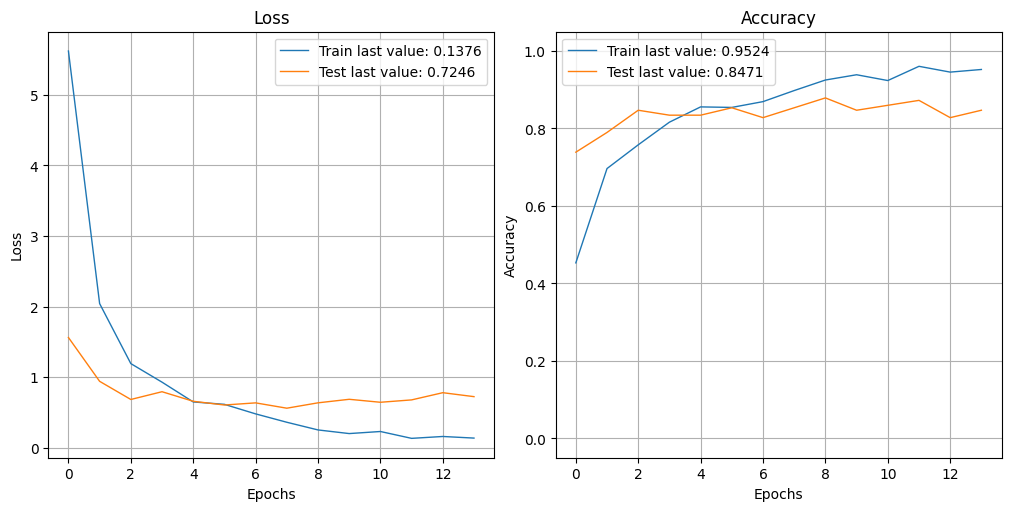

In [68]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [69]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8790
Test Accuracy       :  0.7595


On a une grande baisse de score lorsqu'on teste notre modèle sur un nouveau dataset (Test)

### 2# EarlyStopping = val_loss

In [70]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [71]:
import time

# Enregistrez l'heure de début
start_time = time.time()

# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

# Enregistrez l'heure de fin
end_time = time.time()

# Calculez et affichez la durée
duration = end_time - start_time
print(f"Le temps d'entraînement est de: {duration:.2f} secondes.")

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 5.1224 - accuracy: 0.4626
Epoch 1: val_loss improved from inf to 1.07481, saving model to .\model1_best_weights.h5
12/12 [==============================] - 117s 10s/step - loss: 5.1224 - accuracy: 0.4626 - val_loss: 1.0748 - val_accuracy: 0.7898
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 1.8626 - accuracy: 0.6898
Epoch 2: val_loss improved from 1.07481 to 0.95370, saving model to .\model1_best_weights.h5
12/12 [==============================] - 115s 10s/step - loss: 1.8626 - accuracy: 0.6898 - val_loss: 0.9537 - val_accuracy: 0.7962
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 1.2219 - accuracy: 0.7497
Epoch 3: val_loss improved from 0.95370 to 0.89262, saving model to .\model1_best_weights.h5
12/12 [==============================] - 115s 10s/step - loss: 1.2219 - accuracy: 0.7497 - val_loss: 0.8926 - val_accuracy: 0.8153
Epoch 4/50
12/12 [==============================] 

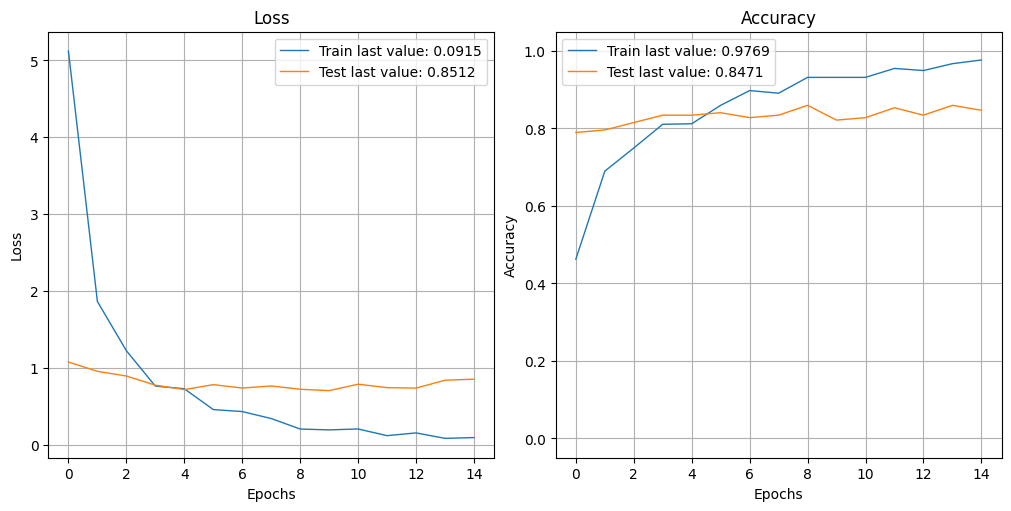

In [72]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [74]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Loss     :  {:.4f}".format(loss))
print("Validation Accuracy :  {:.4f}".format(accuracy))

print("")

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Loss           :  {:.4f}".format(loss))
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Loss     :  0.7027
Validation Accuracy :  0.8217

Test Loss           :  1.3350
Test Accuracy       :  0.8165


La qualité n'a pas énormément baissé lorsqu'on a testé ce modèle sur un nouveau dataset (Test)

### Conclusion:

Il vaut mieux utiliser le val_loss pour le Early Stopping

**Modèle de forte complexité:**
- Nb_Epochs = 15
- test_loss = 1.335
- test_accuracy = 0.8165
- temps = 1722.07 secondes

## CE6 Vous avez présenté une synthèse comparative des différents modèles, par exemple sous forme de tableau. 

In [3]:
import pandas as pd

data = {
    "Modèle": ["Perceptron multicouche", "Modèle simple CNN", "VGG16 + Transfer Learning"],
    "Nb_Epochs": [6, 9, 15],
    "test_loss": [2072.2900, 1.9006, 1.335],
    "test_accuracy": [0.3544, 0.3418, 0.8165],
    "temps (s)": [21.11, 162.67, 1722.07]
}

df = pd.DataFrame(data)
df.set_index('Modèle', inplace=True)

def highlight_cells(col):
    # Dictionnaire pour mapper les colonnes aux fonctions appropriées
    mappers = {
        'Nb_Epochs': min,
        'test_loss': min,
        'test_accuracy': max,
        'temps (s)': min
    }
    
    if col.name in mappers:
        criteria = mappers[col.name](col)
        return ['background-color: green' if v == criteria else '' for v in col]
    return [''] * len(col)

styled_df = df.style.apply(highlight_cells)
styled_df


,Nb_Epochs,test_loss,test_accuracy,temps (s)
Modèle,,,,
Perceptron multicouche,6,2072.290000,0.354400,21.110000
Modèle simple CNN,9,1.900600,0.341800,162.670000
VGG16 + Transfer Learning,15,1.335000,0.816500,1722.070000
